In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['font.family'] = ['Arial Unicode MS'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
sns.set_style('whitegrid',{'font.sans-serif':['Arial Unicode MS','Arial']})

warnings.filterwarnings('ignore')

%matplotlib inline

/Users/wangyutian/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# 载入数据

In [2]:
%%time
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

CPU times: user 10.4 s, sys: 965 ms, total: 11.4 s
Wall time: 11.4 s


# 数据探索

In [6]:
train_df.dtypes

ID_code     object
target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
var_4      float64
var_5      float64
var_6      float64
var_7      float64
var_8      float64
var_9      float64
var_10     float64
var_11     float64
var_12     float64
var_13     float64
var_14     float64
var_15     float64
var_16     float64
var_17     float64
var_18     float64
var_19     float64
var_20     float64
var_21     float64
var_22     float64
var_23     float64
var_24     float64
var_25     float64
var_26     float64
var_27     float64
            ...   
var_170    float64
var_171    float64
var_172    float64
var_173    float64
var_174    float64
var_175    float64
var_176    float64
var_177    float64
var_178    float64
var_179    float64
var_180    float64
var_181    float64
var_182    float64
var_183    float64
var_184    float64
var_185    float64
var_186    float64
var_187    float64
var_188    float64
var_189    float64
var_190    float64
var_191    f

可以看到数据类型都为float64，在计算量大是时候，需要修改数据类型，减少内存占用

In [3]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [4]:
train_df, NAlist = reduce_mem_usage(train_df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276153564453  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_67
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_143
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_144
dtype before:  float64
dtype af

In [5]:
test_df, NAlist = reduce_mem_usage(test_df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017364501953  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

dtype after:  float32
******************************
******************************
Column:  var_68
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_69
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_70
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_71
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_72
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_73
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_74
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_75
dtype before:  float64
dtype after:  fl

dtype after:  float32
******************************
******************************
Column:  var_137
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_138
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_139
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_140
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_141
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_142
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_143
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_144
dtype before:  float64
dtype af

In [4]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [5]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return np.transpose(tt)

In [8]:
%%time
missing_data(train_df)

CPU times: user 1.73 s, sys: 364 ms, total: 2.09 s
Wall time: 2.25 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [9]:
%%time
missing_data(train_df)

CPU times: user 1.54 s, sys: 112 ms, total: 1.65 s
Wall time: 1.65 s


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


1.训练数据和测试数据分别有200000条数据  
2.一共有200个特征，var_0-var_199  
3.没有缺失数据

In [10]:
%%time
train_df.describe()

CPU times: user 1.64 s, sys: 125 ms, total: 1.77 s
Wall time: 1.76 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
%%time
test_df.describe()

CPU times: user 1.71 s, sys: 120 ms, total: 1.83 s
Wall time: 1.83 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


1.训练数据和测试数据的标准差相对来说都较大  
2.min,max,mean,sdt训练集和测试集很接近  
3.各特征均值差异值较大

In [12]:
# 训练集合测试集的特恒散点图，这里只绘个制前16个特征，每个特征取前20条数据
def plot_feature_scatter(df1, df2, features):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(4, 4, figsize=(14, 14))
    
    for feature in features:
        i += 1
        plt.subplot(4, 4, i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show()

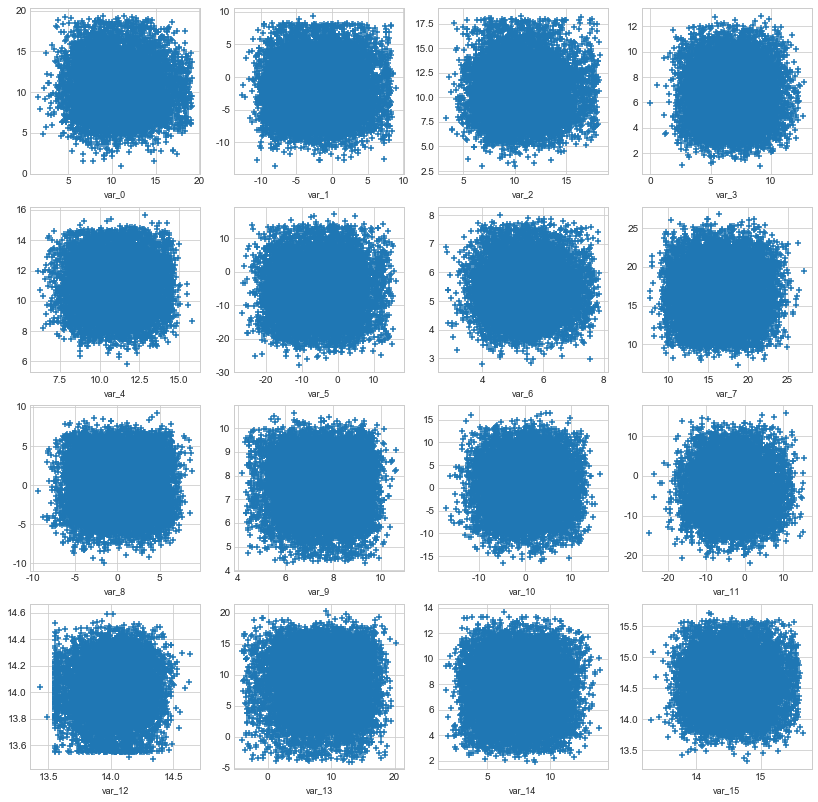

In [13]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
            'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

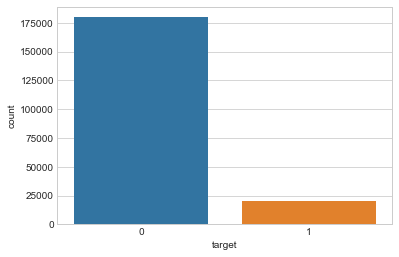

In [14]:
# 看下训练集中正负样本数量
sns.countplot(train_df['target'])

In [15]:
print('训练数据中样本标签为1的数据占比为：{}%'.format(100*train_df['target'].value_counts()[1]/train_df.shape[0]))

训练数据中样本标签为1的数据占比为：10.049%


In [16]:
train_df['target'].value_counts().index

Int64Index([0, 1], dtype='int64')

训练数据正负样本不均衡

# 特征概率分布图

In [17]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(10, 10, figsize=(18, 22))
    
    for feature in features:
        i += 1
        plt.subplot(10, 10, i)
        sns.kdeplot(df1[feature], bw=0.5, label=label1) # bw对数据的拟合程度
        sns.kdeplot(df2[feature], bw=0.5, label=label2)
        plt.xlabel(feature, fontsize=9)
        plt.tick_params(axis='x', labelsize=6, pad=-6) # pad刻度线和标签的距离
        plt.tick_params(axis='y', labelsize=6, pad=-6)
    plt.show()

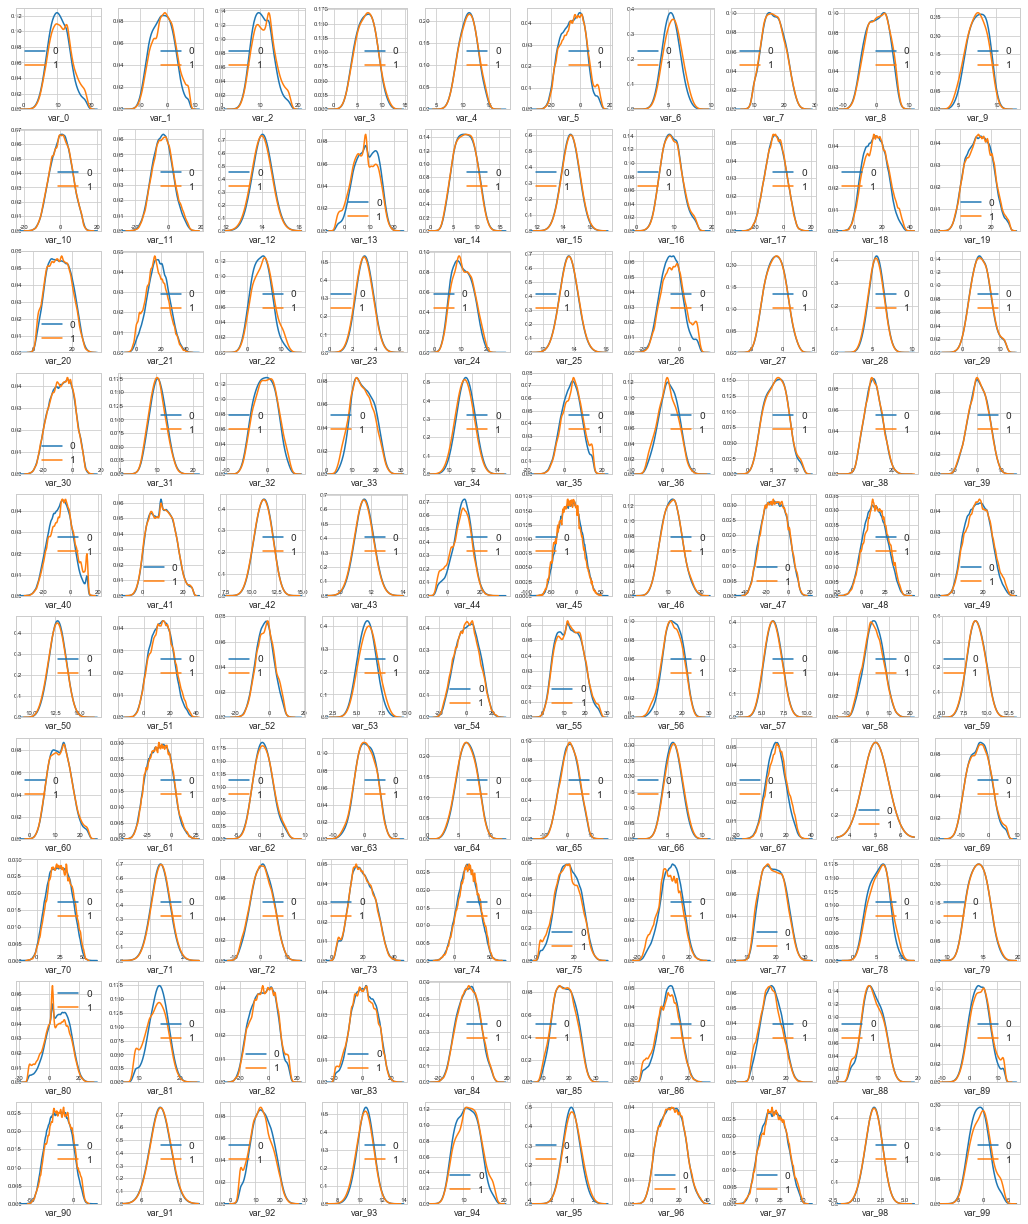

In [18]:
# 训练数据，前100个特征正负样本分布
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

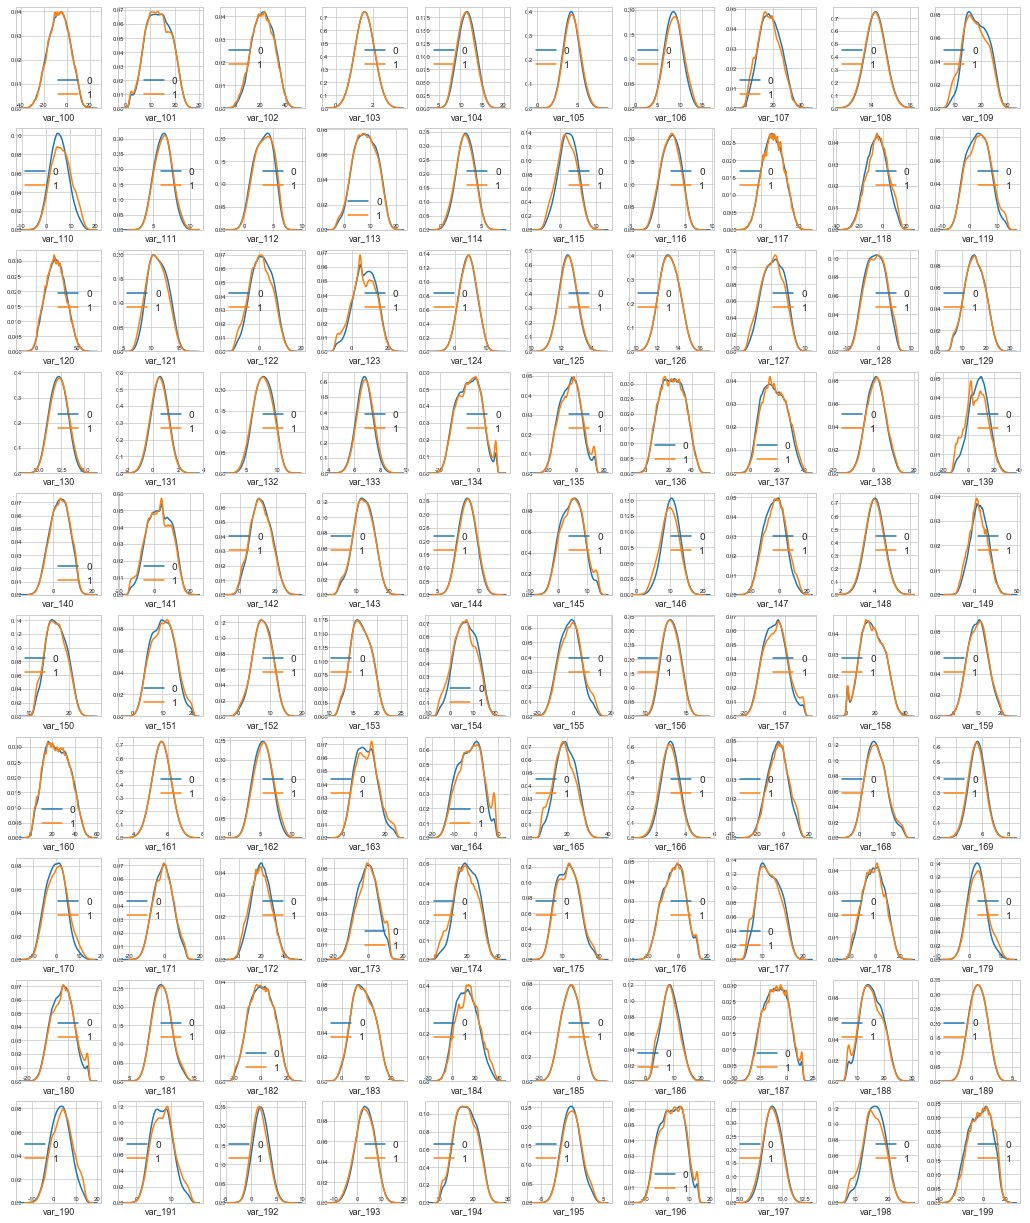

In [19]:
# 后100个特征
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

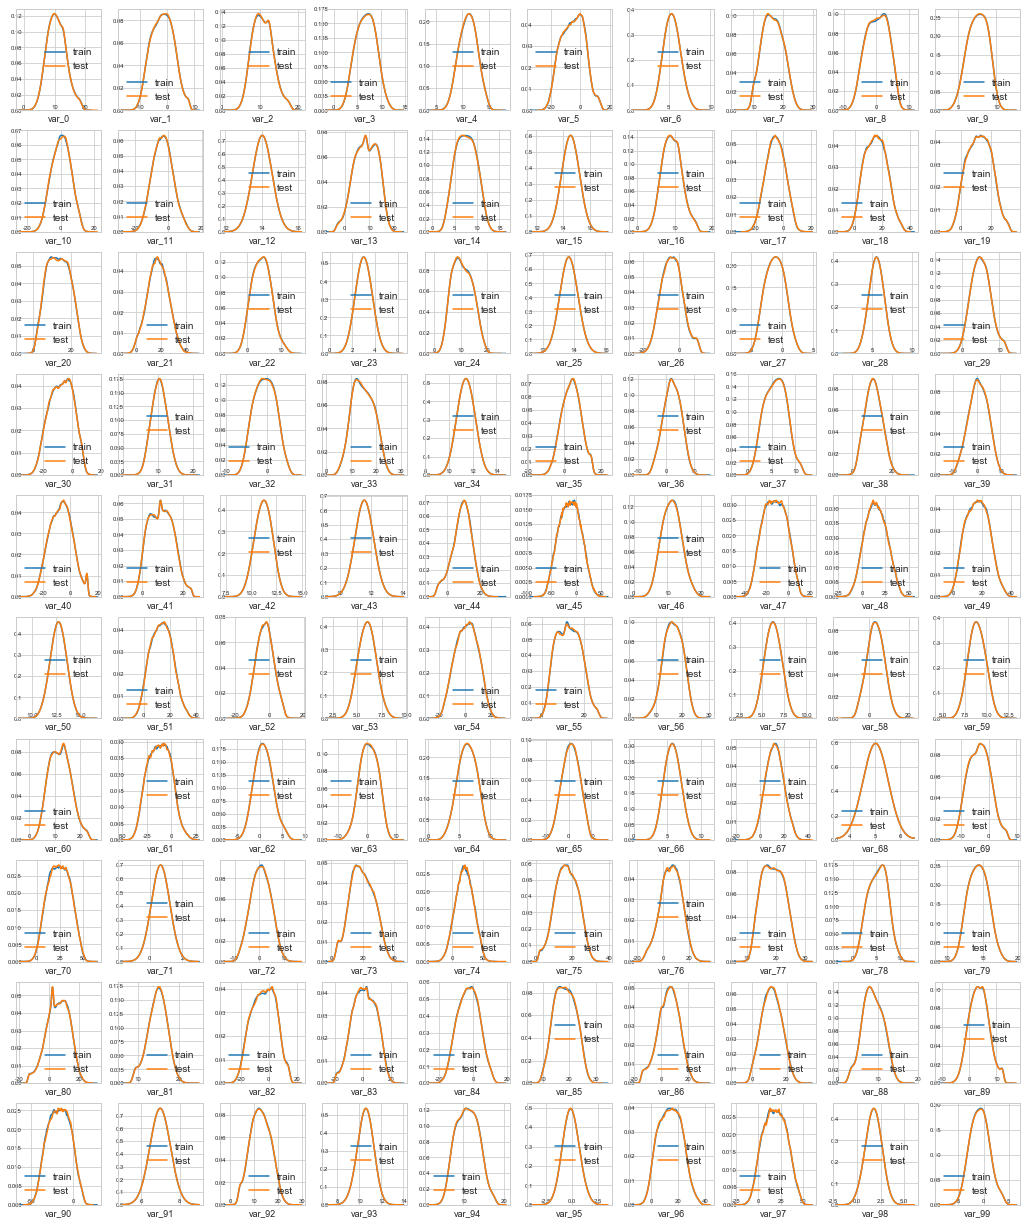

In [20]:
# 训练数据和测试数据的前100个特征分布
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

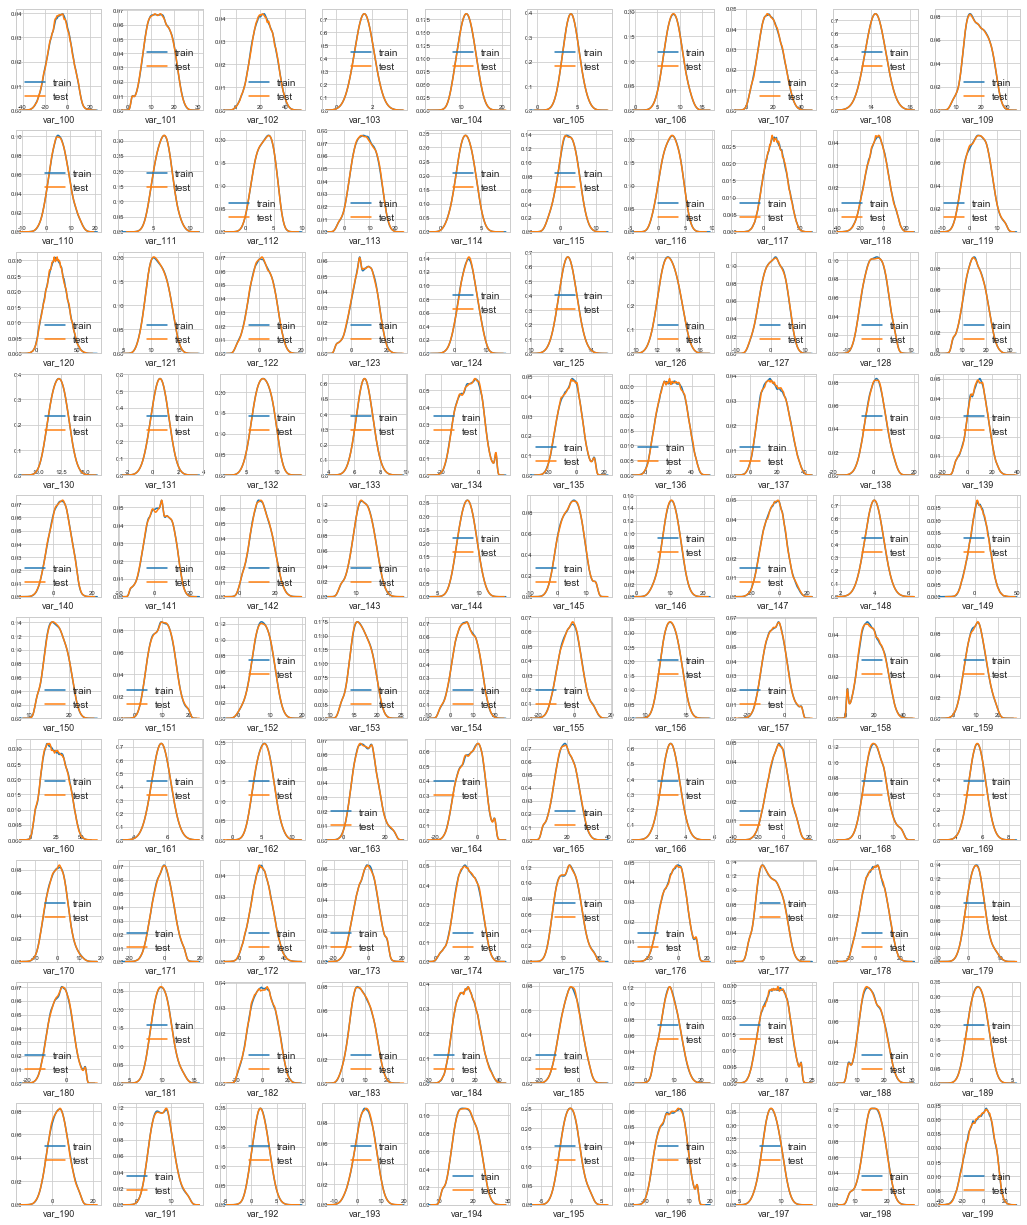

In [21]:
# 训练数据和测试数据的后100个特征分布
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

1.对于正负样本的概率分布，有很多特征有所偏差  
2.对于训练集和测试集，相同特征概率分布基本一致

# mean和std的分布

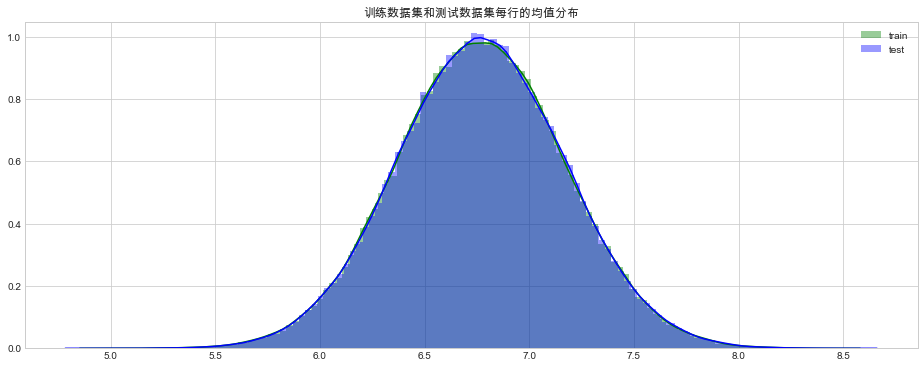

In [22]:
# 训练数据集和测试数据集每行的均值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].mean(axis=1), color='green', bins=120, kde=True,label='train')
sns.distplot(test_df[features].mean(axis=1), color='blue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每行的均值分布')
plt.legend()
plt.show()

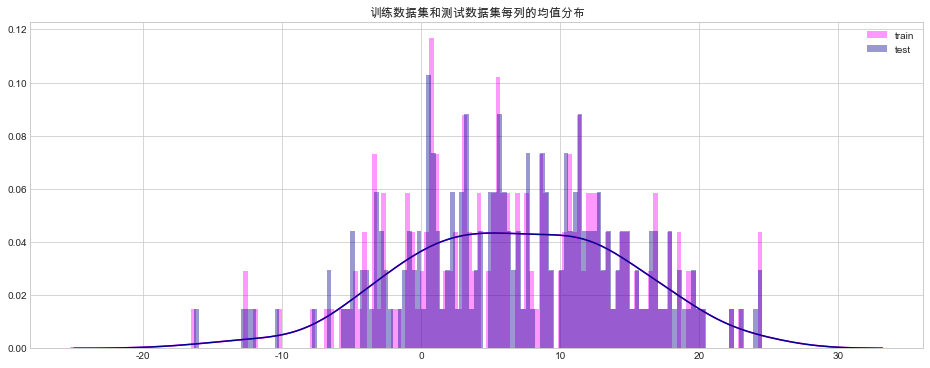

In [23]:
# 训练数据集和测试数据集每列的均值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].mean(axis=0), color='magenta', bins=120, kde=True,label='train')
sns.distplot(test_df[features].mean(axis=0), color='darkblue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每列的均值分布')
plt.legend()
plt.show()

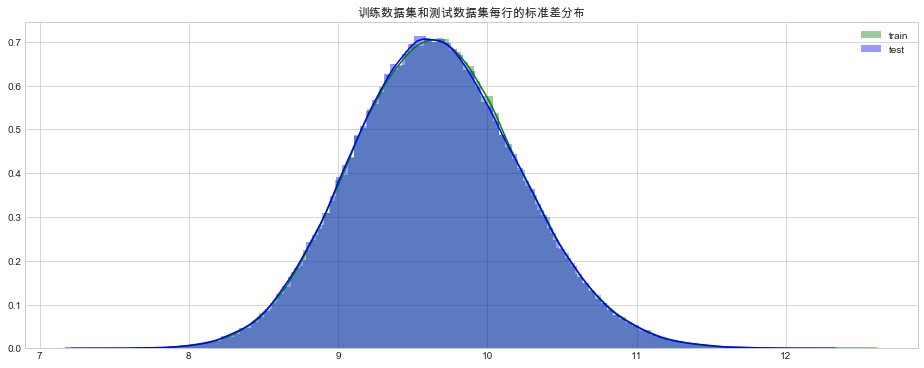

In [24]:
# 训练数据集和测试数据集每行的标准差分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].std(axis=1), color='green', bins=120, kde=True,label='train')
sns.distplot(test_df[features].std(axis=1), color='blue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每行的标准差分布')
plt.legend()
plt.show()

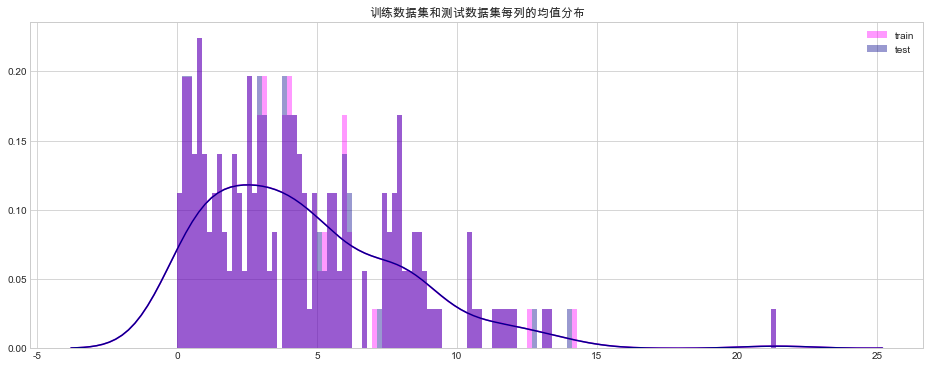

In [25]:
# 训练数据集和测试数据集每列的均值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].std(axis=0), color='magenta', bins=120, kde=True,label='train')
sns.distplot(test_df[features].std(axis=0), color='darkblue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每列的均值分布')
plt.legend()
plt.show()

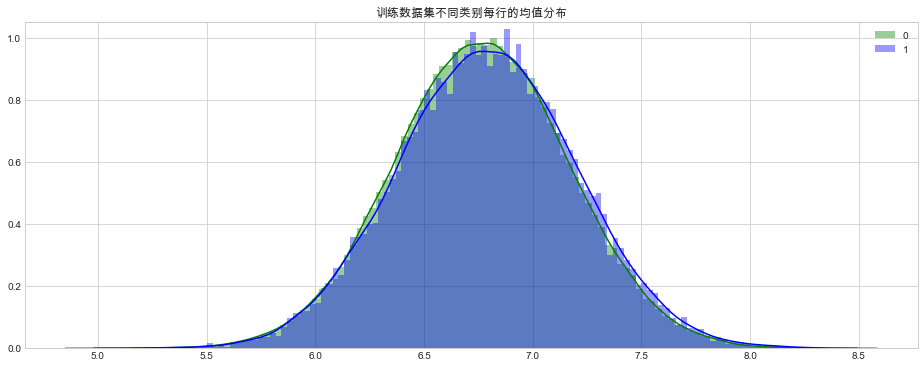

In [26]:
# 训练数据集不同类别每行的均值分布
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].mean(axis=1), color='green', bins=120, kde=True,label='0')
sns.distplot(t1[features].mean(axis=1), color='blue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每行的均值分布')
plt.legend()
plt.show()

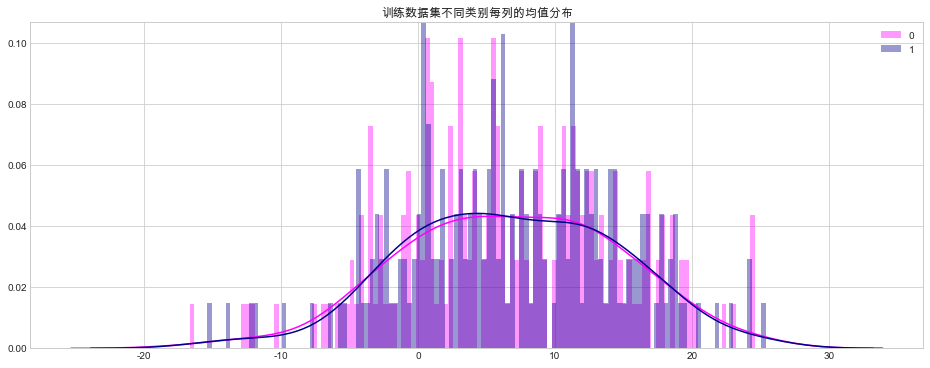

In [27]:
# 训练数据集不同类别每列的均值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].mean(axis=0), color='magenta', bins=120, kde=True,label='0')
sns.distplot(t1[features].mean(axis=0), color='darkblue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每列的均值分布')
plt.legend()
plt.show()

# 最大值最小值的分布

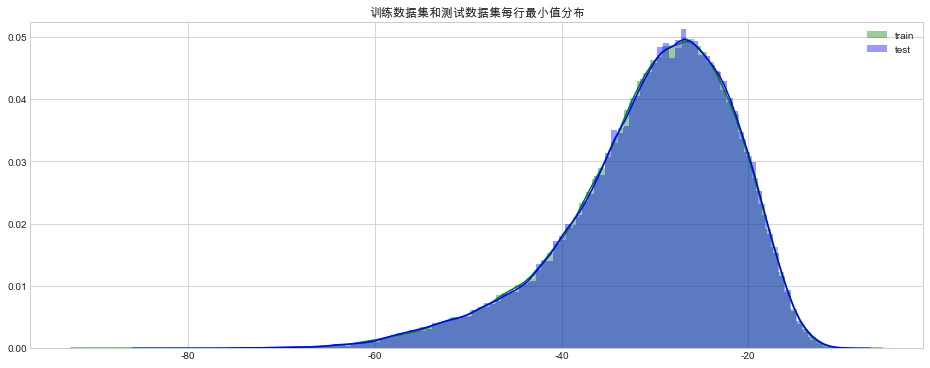

In [28]:
# 训练数据集和测试数据集每行最小值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].min(axis=1), color='green', bins=120, kde=True,label='train')
sns.distplot(test_df[features].min(axis=1), color='blue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每行最小值分布')
plt.legend()
plt.show()

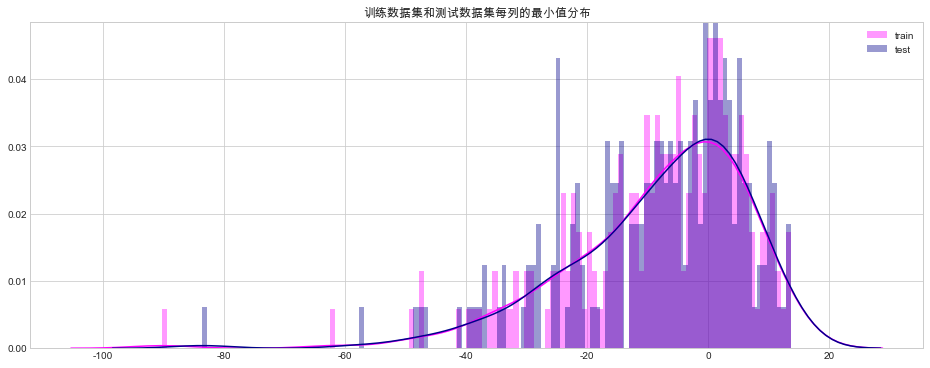

In [29]:
# 训练数据集和测试数据集每列的最小值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].min(axis=0), color='magenta', bins=120, kde=True,label='train')
sns.distplot(test_df[features].min(axis=0), color='darkblue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每列的最小值分布')
plt.legend()
plt.show()

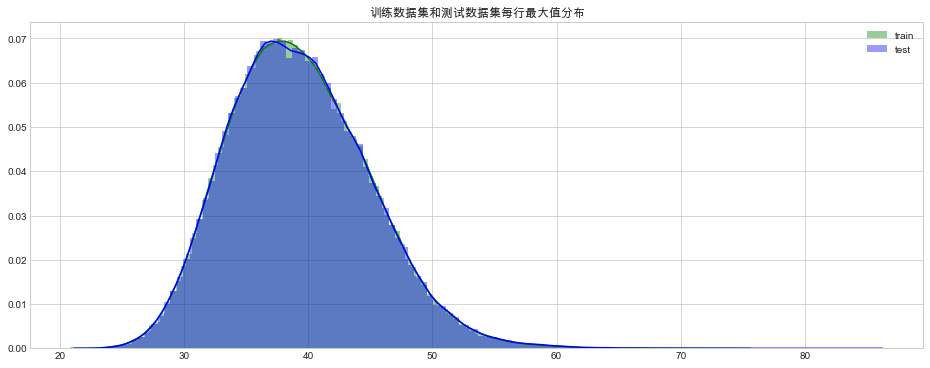

In [30]:
# 训练数据集和测试数据集每行最大值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].max(axis=1), color='green', bins=120, kde=True,label='train')
sns.distplot(test_df[features].max(axis=1), color='blue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每行最大值分布')
plt.legend()
plt.show()

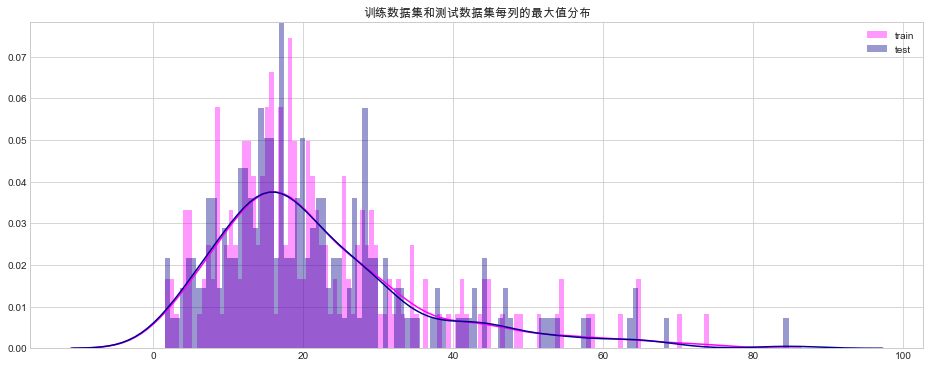

In [31]:
# 训练数据集和测试数据集每列的最大值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].max(axis=0), color='magenta', bins=120, kde=True,label='train')
sns.distplot(test_df[features].max(axis=0), color='darkblue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每列的最大值分布')
plt.legend()
plt.show()

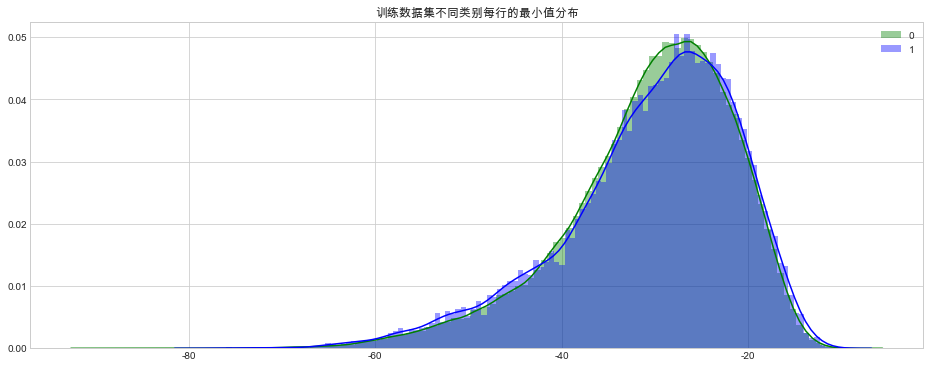

In [32]:
# 训练数据集不同类别每行的最小值分布
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].min(axis=1), color='green', bins=120, kde=True,label='0')
sns.distplot(t1[features].min(axis=1), color='blue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每行的最小值分布')
plt.legend()
plt.show()

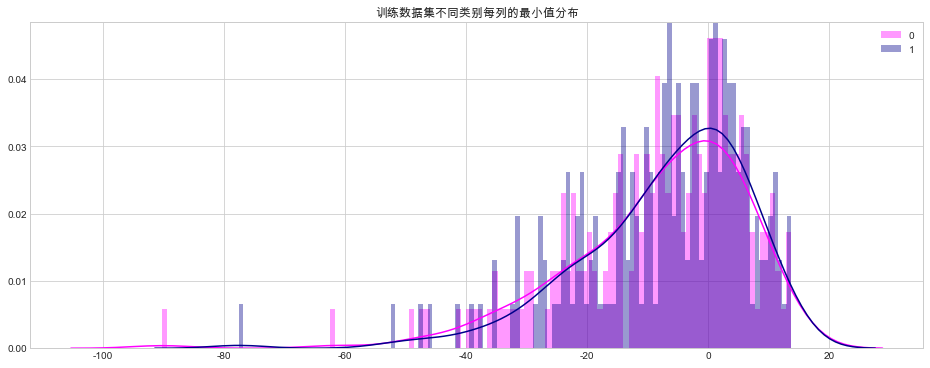

In [33]:
# 训练数据集不同类别每列的最小值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].min(axis=0), color='magenta', bins=120, kde=True,label='0')
sns.distplot(t1[features].min(axis=0), color='darkblue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每列的最小值分布')
plt.legend()
plt.show()

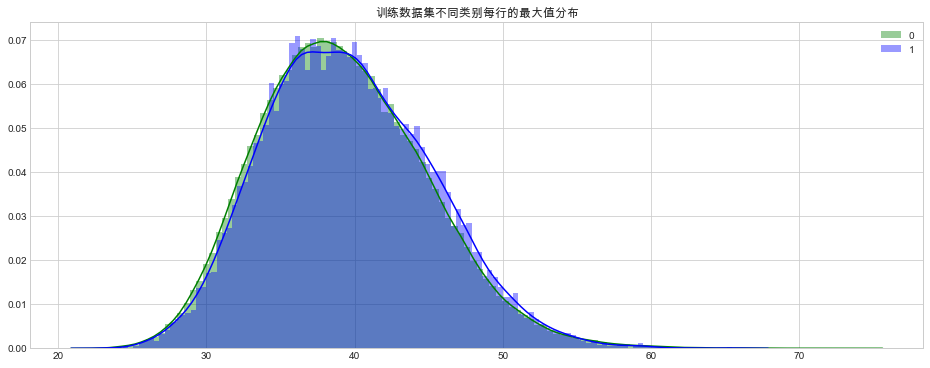

In [34]:
# 训练数据集不同类别每行的最大值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].max(axis=1), color='green', bins=120, kde=True,label='0')
sns.distplot(t1[features].max(axis=1), color='blue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每行的最大值分布')
plt.legend()
plt.show()

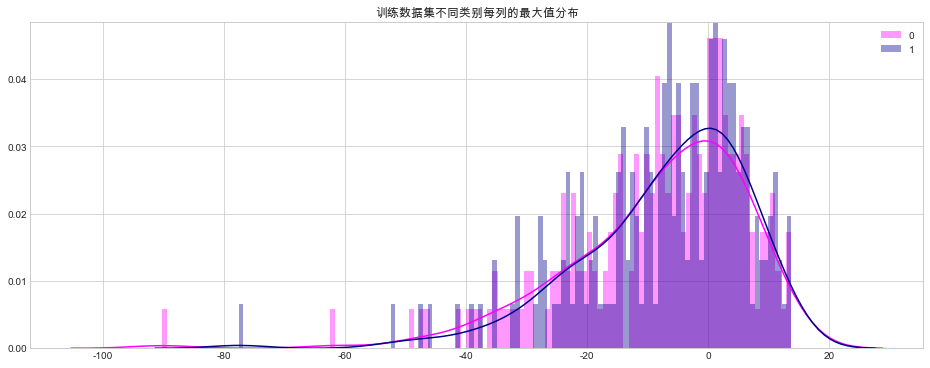

In [35]:
# 训练数据集不同类别每列的最大值分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].min(axis=0), color='magenta', bins=120, kde=True,label='0')
sns.distplot(t1[features].min(axis=0), color='darkblue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每列的最大值分布')
plt.legend()
plt.show()

# 倾斜和峰度分布

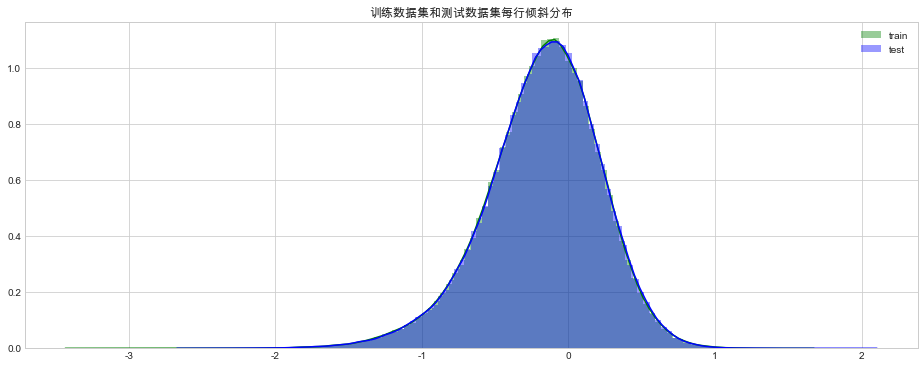

In [36]:
# 训练数据集和测试数据集每行倾斜分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].skew(axis=1), color='green', bins=120, kde=True,label='train')
sns.distplot(test_df[features].skew(axis=1), color='blue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每行倾斜分布')
plt.legend()
plt.show()

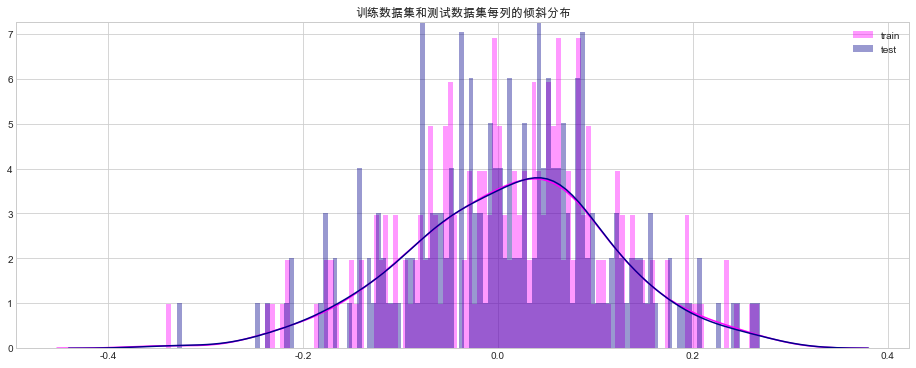

In [37]:
# 训练数据集和测试数据集每列的倾斜分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].skew(axis=0), color='magenta', bins=120, kde=True,label='train')
sns.distplot(test_df[features].skew(axis=0), color='darkblue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每列的倾斜分布')
plt.legend()
plt.show()

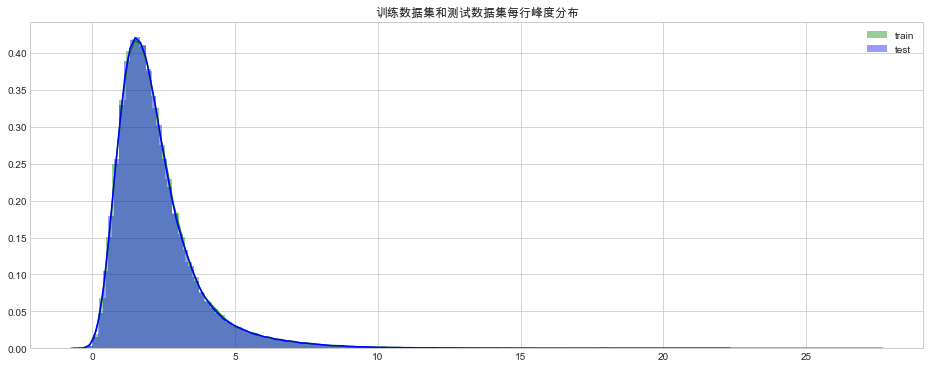

In [38]:
# 训练数据集和测试数据集每行峰度分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].kurtosis(axis=1), color='green', bins=120, kde=True,label='train')
sns.distplot(test_df[features].kurtosis(axis=1), color='blue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每行峰度分布')
plt.legend()
plt.show()

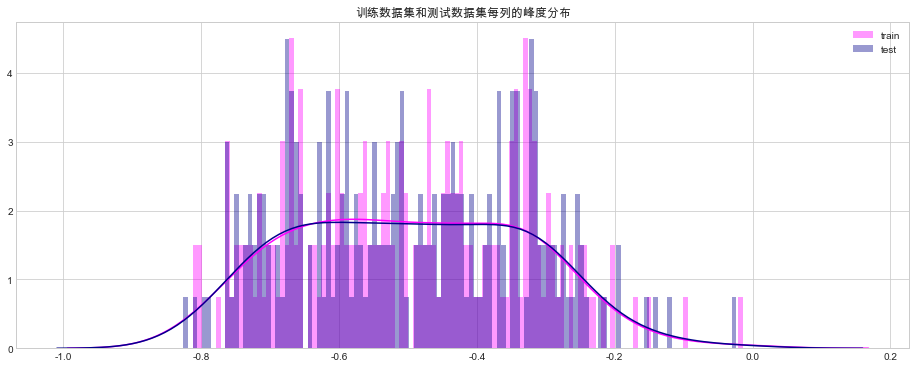

In [39]:
# 训练数据集和测试数据集每列的峰度分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(train_df[features].kurtosis(axis=0), color='magenta', bins=120, kde=True,label='train')
sns.distplot(test_df[features].kurtosis(axis=0), color='darkblue', bins=120, kde=True, label='test')
plt.title('训练数据集和测试数据集每列的峰度分布')
plt.legend()
plt.show()

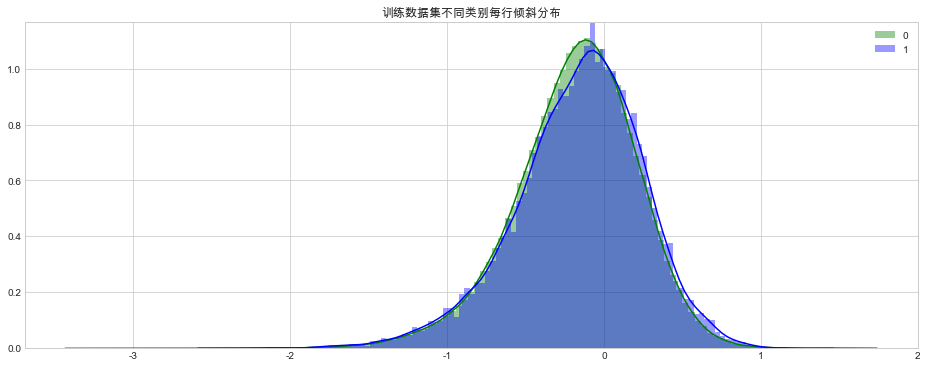

In [40]:
# 训练数据集不同类别每行倾斜分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].skew(axis=1), color='green', bins=120, kde=True,label='0')
sns.distplot(t1[features].skew(axis=1), color='blue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每行倾斜分布')
plt.legend()
plt.show()

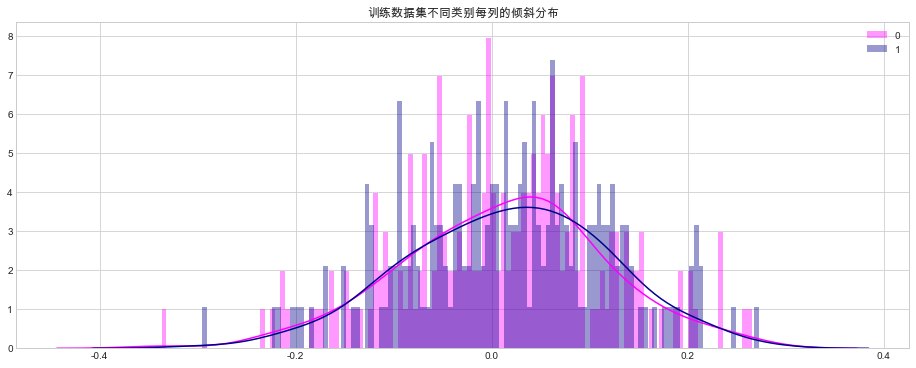

In [41]:
# 训练数据集不同类别每列倾斜分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].skew(axis=0), color='magenta', bins=120, kde=True,label='0')
sns.distplot(t1[features].skew(axis=0), color='darkblue', bins=120, kde=True, label='1')
plt.title('训练数据集不同类别每列的倾斜分布')
plt.legend()
plt.show()

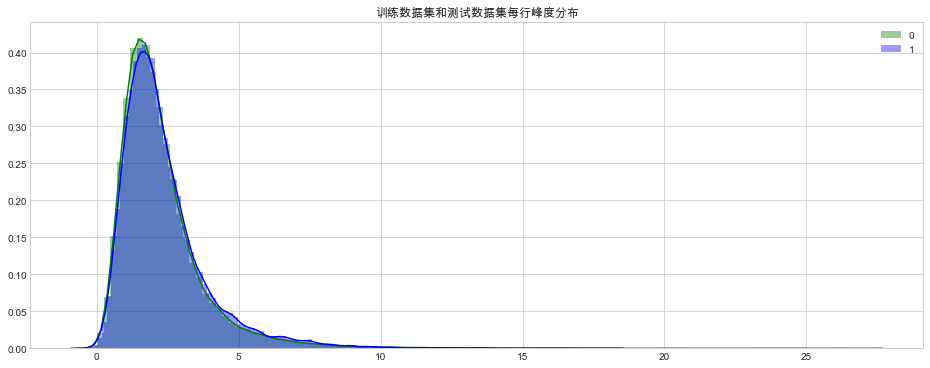

In [42]:
# 训练数据集不同类别每行峰度分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].kurtosis(axis=1), color='green', bins=120, kde=True,label='0')
sns.distplot(t1[features].kurtosis(axis=1), color='blue', bins=120, kde=True, label='1')
plt.title('训练数据集和测试数据集每行峰度分布')
plt.legend()
plt.show()

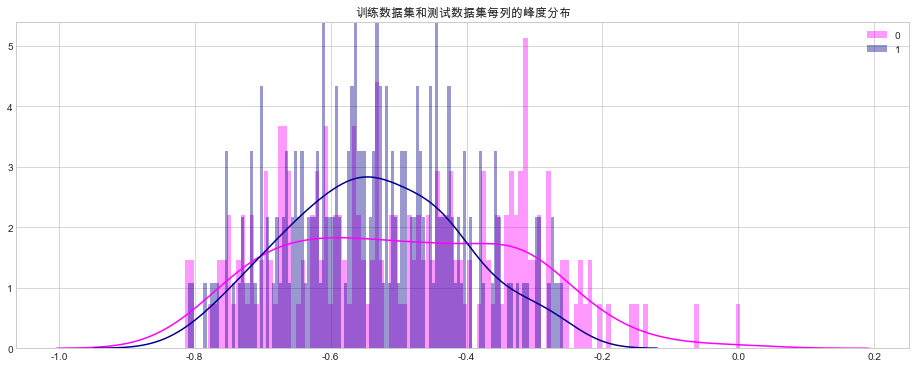

In [43]:
# 训练数据集不同类别每列的峰度分布
plt.figure(figsize=(16, 6))
features = train_df.columns.values[2:202]
sns.distplot(t0[features].kurtosis(axis=0), color='magenta', bins=120, kde=True,label='0')
sns.distplot(t1[features].kurtosis(axis=0), color='darkblue', bins=120, kde=True, label='1')
plt.title('训练数据集和测试数据集每列的峰度分布')
plt.legend()
plt.show()

# 特征间的相关性

In [44]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

CPU times: user 11.2 s, sys: 144 ms, total: 11.3 s
Wall time: 11.3 s


In [45]:
# 相关性最小的特征
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_81,var_165,0.009714
39795,var_165,var_81,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_26,var_139,0.009844
39799,var_139,var_26,0.009844


In [46]:
# 相关性最大的特征
correlations.head(10)

,level_0,level_1,0
0,var_75,var_191,2.703975e-08
1,var_191,var_75,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_177,var_100,3.116544e-07
9,var_100,var_177,3.116544e-07


特征之间的相关性非常小

# 特征的重要程度

In [18]:
%%time
features = train_df.columns.values[2:202]
train_X, test_X, train_y, test_y = train_test_split(train_df[features], train_df['target'], random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

CPU times: user 59 s, sys: 364 ms, total: 59.4 s
Wall time: 59.5 s


In [20]:
%%time
perm = PermutationImportance(rfc_model, random_state=1).fit(test_X, test_y)

CPU times: user 2min 53s, sys: 1.55 s, total: 2min 55s
Wall time: 2min 55s


In [21]:
eli5.show_weights(perm, feature_names = features, top=150)

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


特征的重要性并没有明显的差别

# 重复数据

In [47]:
%%time
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()]) # idxmax获取最大值索引，也就是value
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

CPU times: user 4.53 s, sys: 349 ms, total: 4.88 s
Wall time: 4.89 s


In [48]:
# 训练数据重复值情况
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,108,126,12,91,103,148,71,161,25,125,169,166,133,43
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_166,var_133,var_43
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,2.7306,6.8632,11.4522


In [49]:
# 测试数据重复值情况
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,68,126,108,12,91,103,148,161,25,71,43,166,125,169,133
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


训练数据集合测试数据集的重复性比较一致

# 特征工程

In [29]:
%%time
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 7.81 s, sys: 4.55 s, total: 12.4 s
Wall time: 12.6 s


In [51]:
train_df[train_df.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [52]:
test_df[test_df.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [53]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()

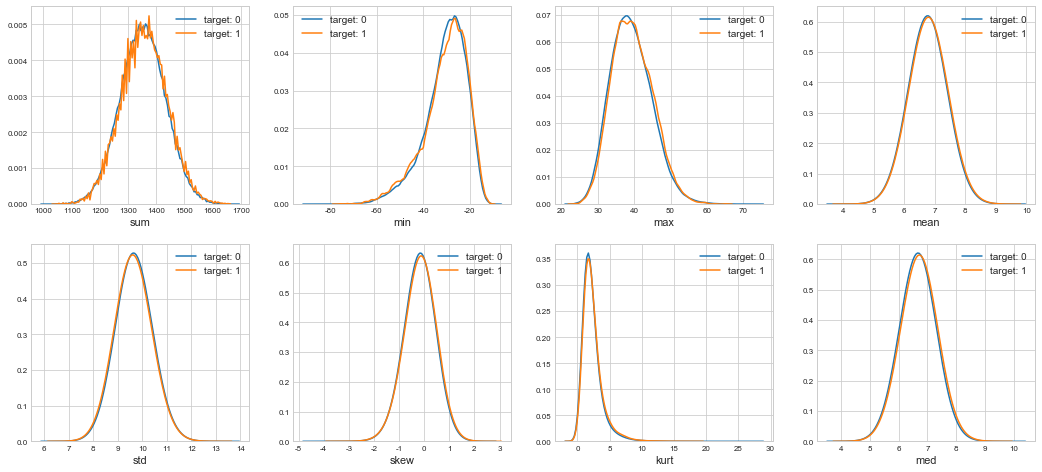

In [54]:
# 训练集新特征分布情况
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

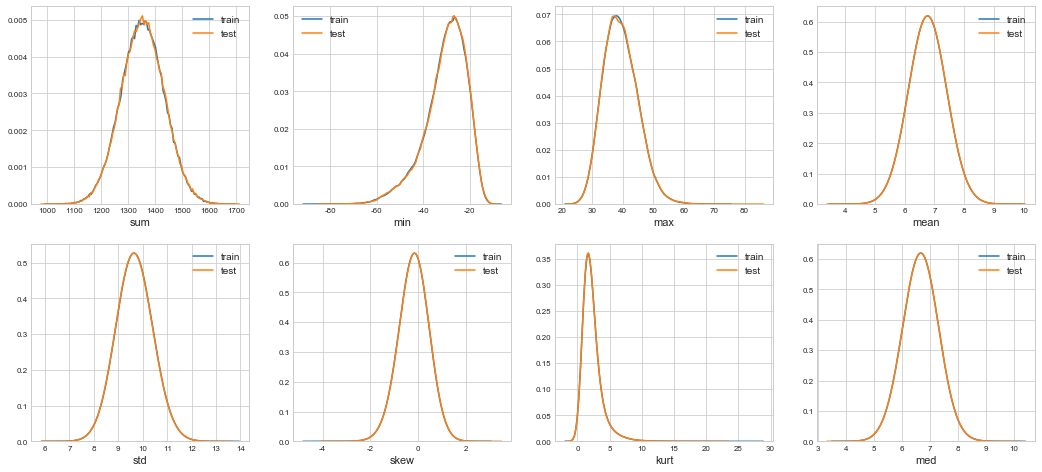

In [55]:
# 训练集和测试集特征分布情况
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

In [56]:
# features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
# for feature in features:
#     train_df['r2_'+feature] = np.round(train_df[feature], 2)
#     test_df['r2_'+feature] = np.round(test_df[feature], 2)
#     train_df['r1_'+feature] = np.round(train_df[feature], 1)
#     test_df['r1_'+feature] = np.round(test_df[feature], 1)

In [57]:
print('Train and test columns: {} {}'.format(len(train_df.columns), len(test_df.columns)))

Train and test columns: 210 209


# PCA主成分分析

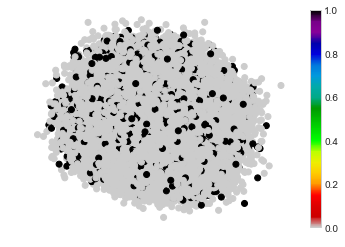

In [82]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
train = train_df[features]
target = train_df['target']
PCA_train_x = PCA(n_components=200, random_state=1).fit_transform(train)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
plt.axis('off')
plt.colorbar()
plt.show()

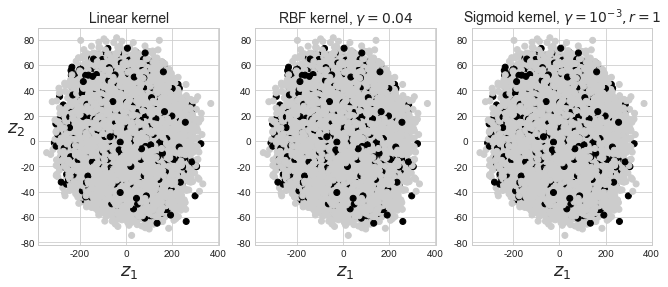

In [83]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

PCA起不到什么帮助

# 建模调参

In [33]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
train = train_df[features]
target = train_df['target']

## 学习率和估计器及其数目

In [54]:
%%time
params = {    
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1, # 学习率先低一些，加快收敛速度
    'num_leaves': 50,
    'max_depth': -1,
    'bagging_fraction': 0.4, # 数据采样
    'feature_fraction': 0.8, # 特征采样
    'metrics': 'auc'
    }

train_data = lgb.Dataset(train, target)
auc_results = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                    early_stopping_rounds=500, verbose_eval=50, show_stdv=True, seed=1)

[50]	cv_agg's auc: 0.845467 + 0.00267989
[100]	cv_agg's auc: 0.867751 + 0.00220921
[150]	cv_agg's auc: 0.87757 + 0.00230731
[200]	cv_agg's auc: 0.882406 + 0.00193934
[250]	cv_agg's auc: 0.884565 + 0.00224291
[300]	cv_agg's auc: 0.885895 + 0.00248983
[350]	cv_agg's auc: 0.886334 + 0.00262578
[400]	cv_agg's auc: 0.886368 + 0.00270444
[450]	cv_agg's auc: 0.88633 + 0.0026888
[500]	cv_agg's auc: 0.886187 + 0.00246181
[550]	cv_agg's auc: 0.886064 + 0.00242048
[600]	cv_agg's auc: 0.885985 + 0.0024098
[650]	cv_agg's auc: 0.8858 + 0.00232831
[700]	cv_agg's auc: 0.885687 + 0.00231638
[750]	cv_agg's auc: 0.885677 + 0.00240594
[800]	cv_agg's auc: 0.885671 + 0.00231982
[850]	cv_agg's auc: 0.885593 + 0.00211389
[900]	cv_agg's auc: 0.885632 + 0.00201577
CPU times: user 26min 49s, sys: 12.7 s, total: 27min 2s
Wall time: 3min 37s


In [55]:
print('best n_estimators:', len(auc_results['auc-mean']))
print('best cv score:', auc_results['auc-mean'][-1])

best n_estimators: 434
best cv score: 0.8863949868729779


最大迭代次数434次，看来在learning rate为0.1时，1000次最大迭代次数满足需求，但在后面减小学习率时需要增加迭代次数

## max_depth和num_leaves

In [56]:
%%time
# 改变num_leaves，也可以使用GridSearchCV进行参数调整
params = {    
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1, # 学习率先低一些，加快收敛速度
    'num_leaves': 30,
    'max_depth': -1,
    'bagging_fraction': 0.4, # 数据采样
    'feature_fraction': 0.8, # 特征采样
    'metrics': 'auc'
    }

train_data = lgb.Dataset(train, target)
auc_results = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                    early_stopping_rounds=500, verbose_eval=50, show_stdv=True, seed=1)
print('best n_estimators:', len(auc_results['auc-mean']))
print('best cv score:', auc_results['auc-mean'][-1])

[50]	cv_agg's auc: 0.841152 + 0.00272567
[100]	cv_agg's auc: 0.865436 + 0.00212606
[150]	cv_agg's auc: 0.875921 + 0.00192532
[200]	cv_agg's auc: 0.881712 + 0.00173886
[250]	cv_agg's auc: 0.885143 + 0.00183745
[300]	cv_agg's auc: 0.886979 + 0.00180572
[350]	cv_agg's auc: 0.888005 + 0.001915
[400]	cv_agg's auc: 0.888433 + 0.00179801
[450]	cv_agg's auc: 0.888621 + 0.00183131
[500]	cv_agg's auc: 0.888551 + 0.00172877
[550]	cv_agg's auc: 0.888372 + 0.00178665
[600]	cv_agg's auc: 0.888236 + 0.00173397
[650]	cv_agg's auc: 0.888098 + 0.00180883
[700]	cv_agg's auc: 0.88805 + 0.00180513
[750]	cv_agg's auc: 0.887984 + 0.0019212
[800]	cv_agg's auc: 0.887852 + 0.0019474
[850]	cv_agg's auc: 0.88774 + 0.00200429
[900]	cv_agg's auc: 0.887576 + 0.00198289
[950]	cv_agg's auc: 0.887384 + 0.00207099
best n_estimators: 476
best cv score: 0.8886555609673721
CPU times: user 19min 38s, sys: 5.15 s, total: 19min 43s
Wall time: 2min 33s


In [58]:
%%time
params = {    
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'learning_rate': 0.1, # 学习率先低一些，加快收敛速度
    'num_leaves': 70,
    'max_depth': -1,
    'bagging_fraction': 0.4, # 数据采样
    'feature_fraction': 0.8, # 特征采样
    'metrics': 'auc'
    }

train_data = lgb.Dataset(train, target)
auc_results = lgb.cv(params, train_data, num_boost_round=1000, nfold=5, stratified=False, shuffle=True,
                    early_stopping_rounds=500, verbose_eval=50, show_stdv=True, seed=1)
print('best n_estimators:', len(auc_results['auc-mean']))
print('best cv score:', auc_results['auc-mean'][-1])

[50]	cv_agg's auc: 0.845945 + 0.00226097
[100]	cv_agg's auc: 0.868255 + 0.0019385
[150]	cv_agg's auc: 0.876889 + 0.00205022
[200]	cv_agg's auc: 0.881188 + 0.00187066
[250]	cv_agg's auc: 0.883342 + 0.00177529
[300]	cv_agg's auc: 0.88444 + 0.00171839
[350]	cv_agg's auc: 0.884809 + 0.00171508
[400]	cv_agg's auc: 0.884936 + 0.00171176
[450]	cv_agg's auc: 0.884981 + 0.00188401
[500]	cv_agg's auc: 0.884993 + 0.00184967
[550]	cv_agg's auc: 0.88501 + 0.00179883
[600]	cv_agg's auc: 0.88499 + 0.00183568
[650]	cv_agg's auc: 0.885145 + 0.00188698
[700]	cv_agg's auc: 0.885123 + 0.00197212
[750]	cv_agg's auc: 0.885274 + 0.00208977
[800]	cv_agg's auc: 0.885159 + 0.0019632
[850]	cv_agg's auc: 0.885277 + 0.00195563
[900]	cv_agg's auc: 0.885187 + 0.00183667
[950]	cv_agg's auc: 0.885298 + 0.00184839
[1000]	cv_agg's auc: 0.885378 + 0.00182986
best n_estimators: 990
best cv score: 0.8853926476722339
CPU times: user 34min 54s, sys: 7.8 s, total: 35min 1s
Wall time: 4min 29s


从auc可以看出，应该减小num_leaves以提高模型准确率

## 除此之外还需调整min_data_in_leaf，min_sum_hessian_in_leaf，feature_fraction，bagging_fraction参数来降低过拟合

In [115]:
param = {'objective' : 'binary', 
          'boost': 'gbdt',
          'metric': 'auc',
          'tree_learner' : 'serial',
          'is_unbalance': True,
          'boost_from_average': 'false',
          'max_depth': -1,
          'num_leaves' : 13,
          'num_threads': 8,
          'learning_rate': 0.0083,
          'feature_fraction': 0.0405,
          'bagging_freq' : 5,
          'bagging_fraction' : 0.331,
          'min_data_in_leaf' : 80,
          'min_sum_hessian_in_leaf' : 10.0,
          'verbosity' : 1}

In [116]:
%%time
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1012)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.908566	valid_1's auc: 0.884503
[2000]	training's auc: 0.914762	valid_1's auc: 0.888235
[3000]	training's auc: 0.919977	valid_1's auc: 0.890504
[4000]	training's auc: 0.924606	valid_1's auc: 0.891516
[5000]	training's auc: 0.928756	valid_1's auc: 0.892429
[6000]	training's auc: 0.932693	valid_1's auc: 0.893035
[7000]	training's auc: 0.93651	valid_1's auc: 0.893161
[8000]	training's auc: 0.940004	valid_1's auc: 0.893377
[9000]	training's auc: 0.943402	valid_1's auc: 0.893407
[10000]	training's auc: 0.946616	valid_1's auc: 0.893481
[11000]	training's auc: 0.949703	valid_1's auc: 0.893406
[12000]	training's auc: 0.952676	valid_1's auc: 0.893346
Early stopping, best iteration is:
[9589]	training's auc: 0.945342	valid_1's auc: 0.893588
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.907644	valid_1's auc: 0.893785
[2000]	training's auc: 0.914013	valid

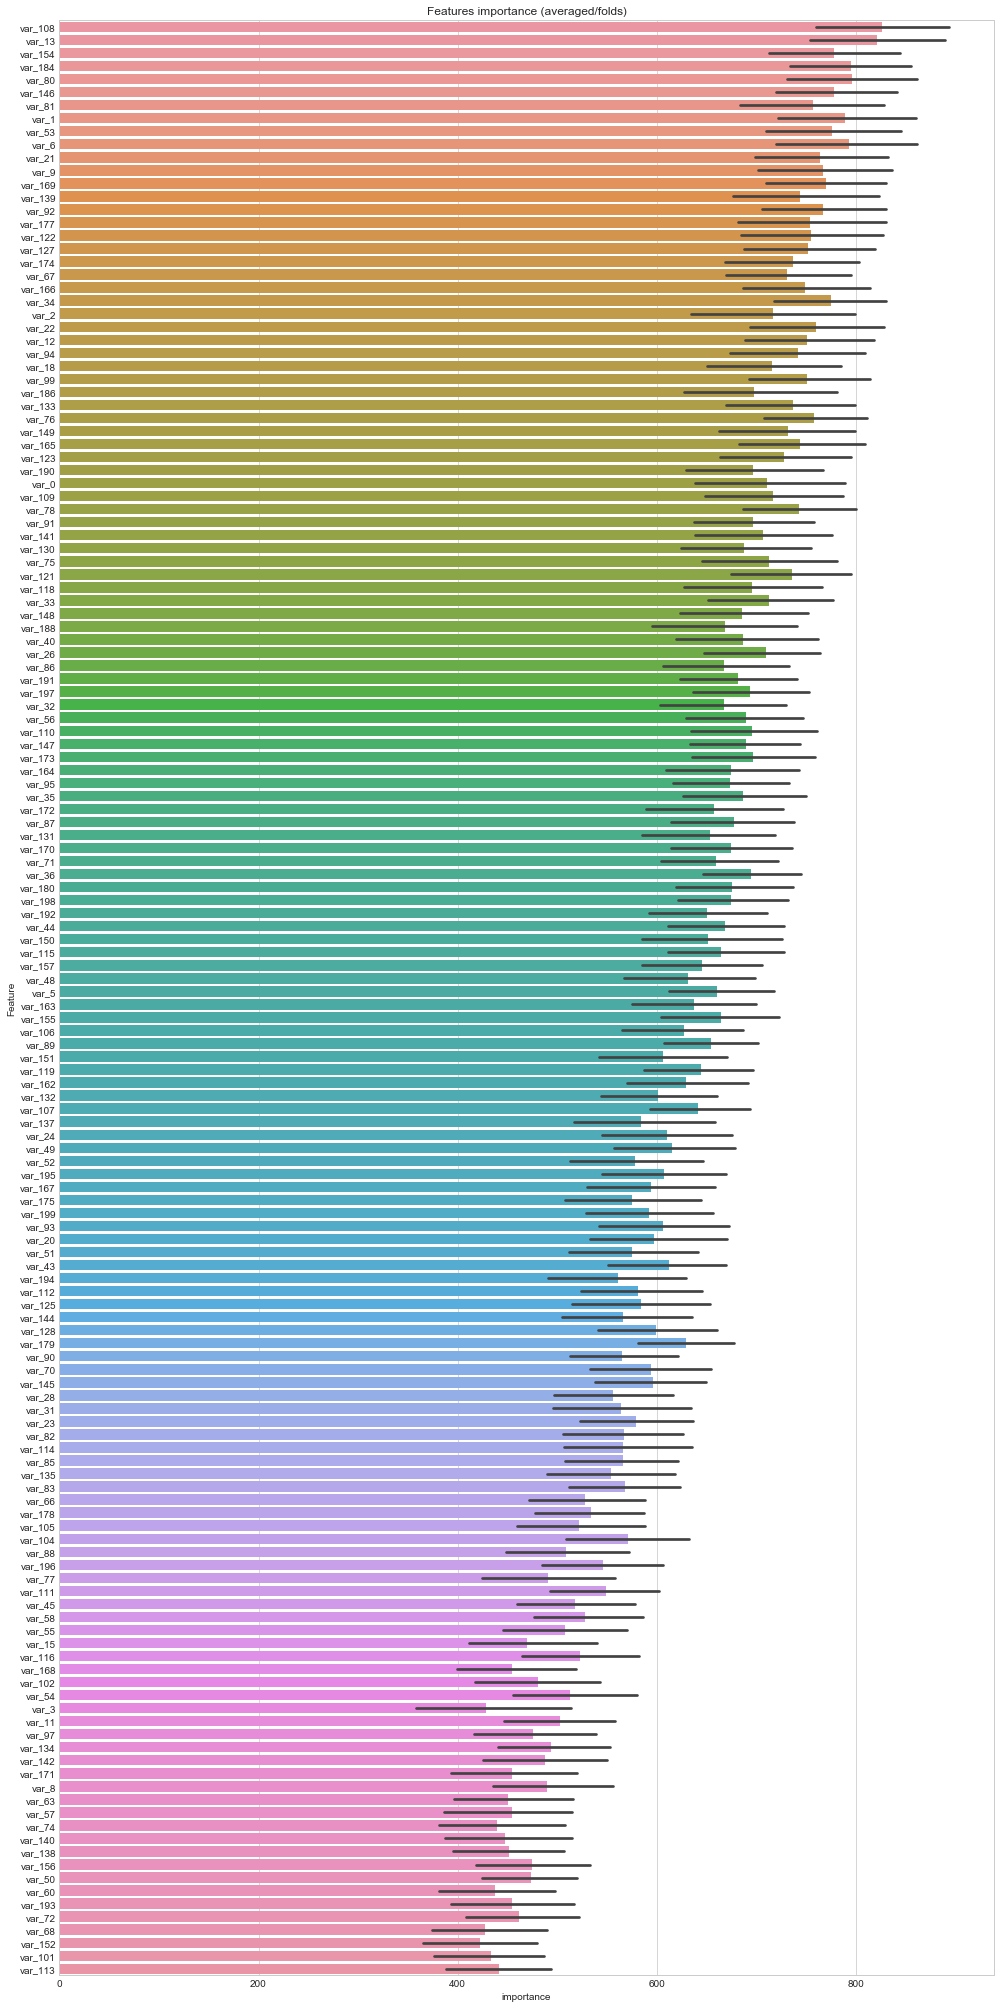

In [48]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [186]:
submission_lgb = pd.DataFrame({
        "ID_code": test_df["ID_code"],
        "target": predictions
    })
submission_lgb.to_csv('./data/submission_lgb.csv', index=False)